In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Load the dataset
df = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [25]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   1

# **Data Cleaning**

* Since it makes no sense for the analysis to have entries without a known customer, we remove entries with null values in the Customer ID column.
* We don't need cancelled transactions, so we remove any invoice that starts with the letter 'C'.
* We convert the datetime string values into proper datetime objects.
* Since the Price and Quantity columns contain non-positive values, we should remove them from the analysis.
* We create a new column that represents the total price of the sale.

In [26]:
df = df.dropna(subset=['Customer ID'])

df = df[~df['Invoice'].str.startswith('C', na=False)]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df = df[df['Quantity'] > 0]

df = df[df['Price'] > 0]

df['TotalPrice'] = df['Quantity'] * df['Price']

In [27]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.5+ MB
None
            Quantity                    InvoiceDate          Price  \
count  805549.000000                         805549  805549.000000   
mean       13.290522  2011-01-02 10:24:44.106814208       3.206561   
min         1.000000            2009-12-01 07:4

# RFM Analysis

**R**: Recency = (Reference Date - Latest Purchase Date) in days<br>
**F**: Frequency = Number of transactions<br>
**M**: Monetary Value = Total money spent by the customer

In [28]:
# Set a reference date (1 day after the last invoice in the dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()
"""The agg() function applies the lambda, unnique, and sum functions to the 'InvoiceDate'
'Invoice', and 'TotalPrice' columns per customer (due to using groupby())."""


# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Remove customers with zero monetary value (maybe ones that only returned items)
rfm = rfm[rfm['Monetary'] > 0]

In [29]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


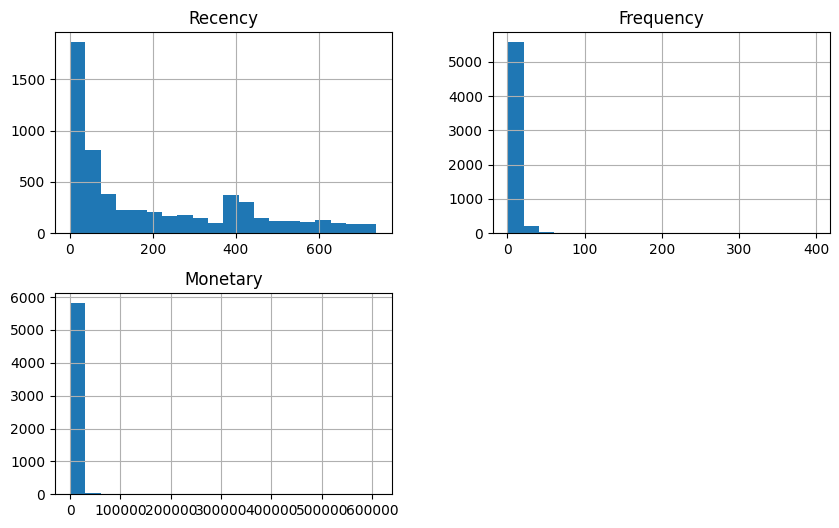

In [30]:
rfm[['Recency', 'Frequency', 'Monetary']].hist(bins=20, figsize=(10, 6))
plt.show()

#### Log transformation reduces skewness by compressing the long tail of a right-skewed distribution, which makes it easier to interpret.
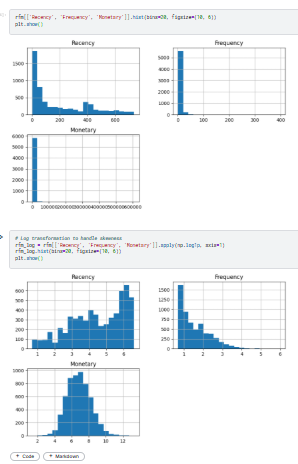

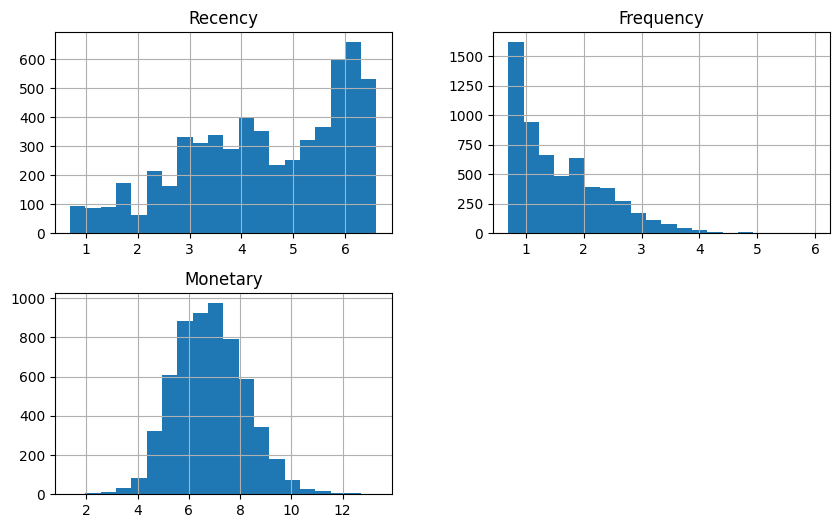

In [31]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log1p, axis=1)
rfm_log.hist(bins=20, figsize=(10, 6))
plt.show()

#### For better clustering performance, standard scaling is used on rfm values. Since they are on different scales, comparing them directly can bias the analysis toward variables with larger magnitudes.

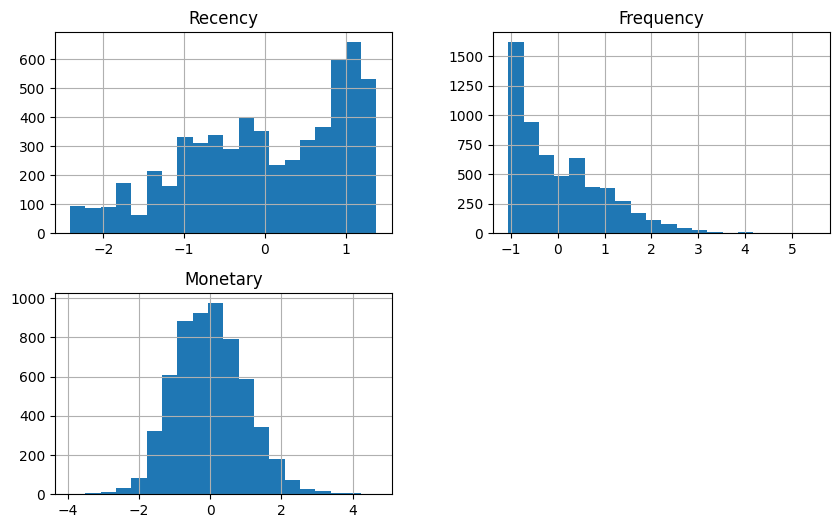

In [32]:
# Z-score normalization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

rfm_scaled.hist(bins=20, figsize=(10, 6))
plt.show()

# Determining the optimal number of Clusters
#### Using WCSS (Within-Cluster Sum of Squares), we choose a value for k so that bigger values don't decrease wcss by a significant amount (The Elbow Method).

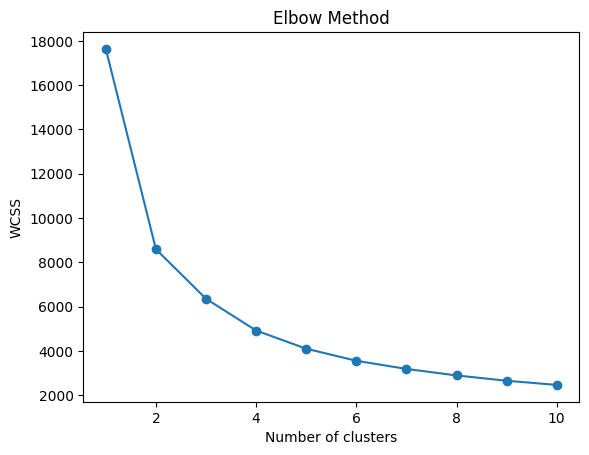

In [33]:
# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    #kmeans.inertia_: Sum of squared distances of samples to their closest cluster center,
    #weighted by the sample weights if provided
    
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [35]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,12,77556.46,2
1,12347.0,2,8,5633.32,2
2,12348.0,75,5,2019.40,3
3,12349.0,19,4,4428.69,1
4,12350.0,310,1,334.40,0


# Analyzing Clusters

In [36]:
# Cluster statistics
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(2)

In [37]:
(cluster_stats.style
   .set_table_styles([
       {'selector': 'th.col_heading', 'props': 'text-align: center;'},
       {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'},
       {'selector': 'td', 'props': 'text-align: center;'}
   ])
   .set_properties(**{'padding': '5px', 'border': '1px solid black'})
)

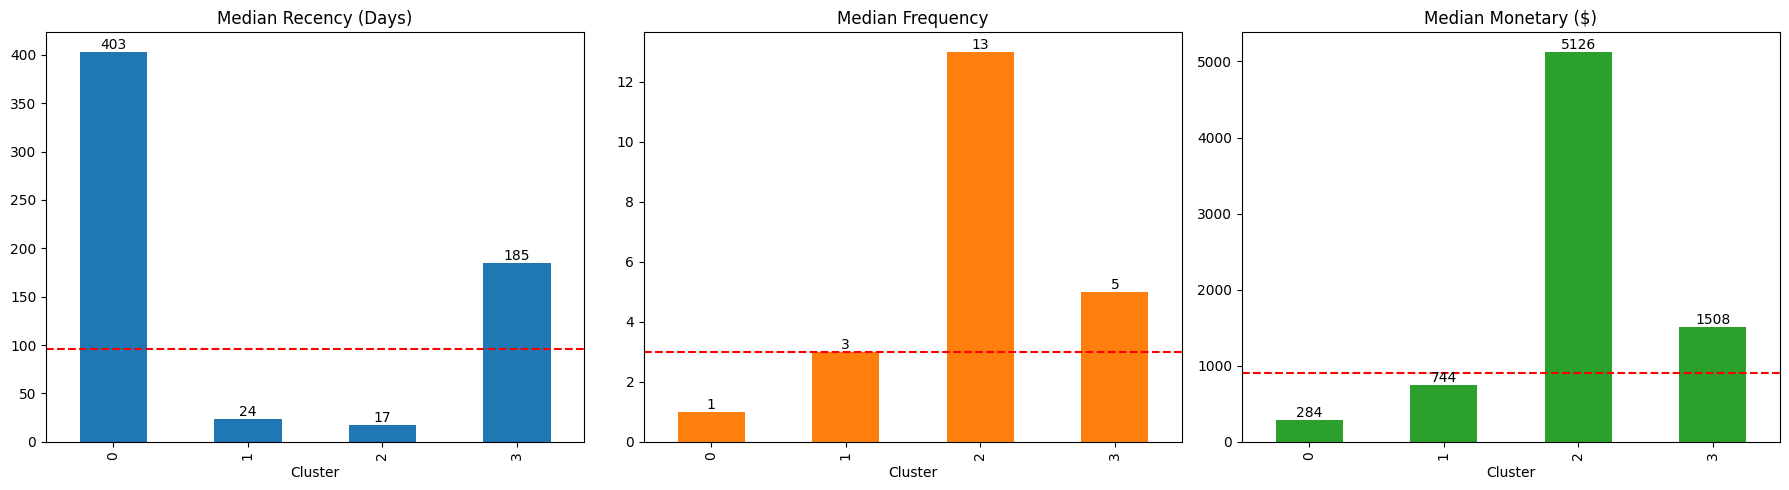

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Median Recency (Lower = Better)
rfm.groupby('Cluster')['Recency'].median().plot(
    kind='bar', ax=axes[0], color='#1f77b4', title='Median Recency (Days)'
)
axes[0].axhline(rfm['Recency'].median(), color='red', linestyle='--')

# Median Frequency (Higher = Better)
rfm.groupby('Cluster')['Frequency'].median().plot(
    kind='bar', ax=axes[1], color='#ff7f0e', title='Median Frequency'
)
axes[1].axhline(rfm['Frequency'].median(), color='red', linestyle='--')

# Median Monetary (Higher = Better)
rfm.groupby('Cluster')['Monetary'].median().plot(
    kind='bar', ax=axes[2], color='#2ca02c', title='Median Monetary ($)'
)
axes[2].axhline(rfm['Monetary'].median(), color='red', linestyle='--')

for ax in axes:
    ax.set_xlabel('Cluster')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0f}", 
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.tight_layout()
plt.show()

* __Cluster 0:__ The average customer hasn't purchased for more than a year. They also don't purchase often. Their average spending is quite low. This cluster contains __"Inactive Customers"__.
* __Cluster 1:__ Very low recency, medium Frequency, and medium Monetary value. The customers in this cluster have bought recently, but can't be considered loyal customers yet. These could be __"Recent Buyers"__.
* __Cluster 2:__ Very low recency, the highest frequency, and the highest spenders _by a large margin_. These are the __"VIPs"__.
* __Cluster 3:__ Medium recency, and realtively high frequency and monetary value. These are our __"Loyal Customers"__.

In [43]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,12,77556.46,2
1,12347.0,2,8,5633.32,2
2,12348.0,75,5,2019.40,3
3,12349.0,19,4,4428.69,1
4,12350.0,310,1,334.40,0


In [45]:
# Save cluster results with labels
rfm['Segment'] = rfm['Cluster'].map({
    0: 'Inactive Customers',
    1: 'Recent Buyers',
    2: 'VIPs',
    3: 'Loyal Customers'
})
rfm.to_csv('rfm_clusters.csv', index=False)

<Figure size 1200x600 with 0 Axes>

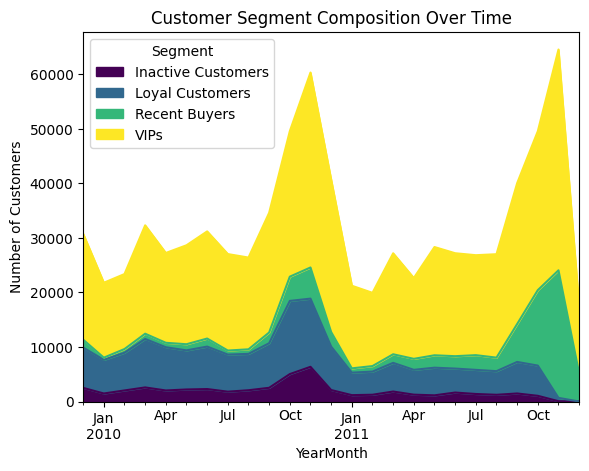

In [46]:
# Merge purchase dates back in (from original data)
segments_with_dates = pd.merge(
    rfm[['Customer ID', 'Segment']],
    df[['Customer ID', 'InvoiceDate']],
    on='Customer ID'
)

# Plot monthly segment composition
segments_with_dates['YearMonth'] = segments_with_dates['InvoiceDate'].dt.to_period('M')
trend = segments_with_dates.groupby(['YearMonth', 'Segment']).size().unstack()

plt.figure(figsize=(12,6))
trend.plot.area(stacked=True, colormap='viridis')
plt.title('Customer Segment Composition Over Time')
plt.ylabel('Number of Customers')
plt.show()

#### The number of customers seems to increase around October, especially VIPs.

# Possible Business Strategies

In [47]:
recommendations = {
    'Inactive Customers': [
        "Win-back email campaign with 20% discount",
        "Survey to understand churn reasons"
    ],
    'Recent Buyers': [
        "Upsell complementary products",
        "Loyalty program introduction"
    ],
    'VIPs': [
        "Exclusive early-access to new products",
        "Personalized thank-you gifts"
    ],
    'Loyal Customers': [
        "Tiered rewards program",
        "Referral bonuses"
    ]
}

pd.DataFrame.from_dict(recommendations, orient='index')\
  .rename(columns=lambda x: f"Action {x+1}")\
  .style.set_properties(**{'text-align': 'left'})

,Action 1,Action 2
Inactive Customers,Win-back email campaign with 20% discount,Survey to understand churn reasons
Recent Buyers,Upsell complementary products,Loyalty program introduction
VIPs,Exclusive early-access to new products,Personalized thank-you gifts
Loyal Customers,Tiered rewards program,Referral bonuses
